In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle


In [3]:
torch.cuda.is_available()


True

In [4]:
DATA_PATH = "D:/Coding/data/astro_dataset_maxia/astro_dataset_maxia"

**1 Hidden Layer w/o Greyscale**

In [5]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                           std=[0.5, 0.5, 0.5]),                     
])

In [12]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [13]:
img, label = train_data[0]
print(img.shape)


torch.Size([3, 128, 128])


In [14]:
class ANN(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [15]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = ANN().to(device)

In [17]:
#MSE issues for classification: gradients become small convergence becomes slow probabilities don’t normalize accuracy is worse
learning_rate = 0.001
weight_decay = lamb = 0.0001



In [18]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [20]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=0.0001
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.9053 | Val Loss: 4.5843 | Train Acc: 32.5745 | Val Acc: 45.5927
Epoch [2/20] Train Loss: 3.9640 | Val Loss: 3.1736 | Train Acc: 45.9437 | Val Acc: 60.9422
Epoch [3/20] Train Loss: 3.0867 | Val Loss: 3.2045 | Train Acc: 49.0480 | Val Acc: 58.5106
Epoch [4/20] Train Loss: 2.9099 | Val Loss: 3.1816 | Train Acc: 53.8079 | Val Acc: 64.1337
Epoch [5/20] Train Loss: 2.3710 | Val Loss: 3.5837 | Train Acc: 58.3195 | Val Acc: 65.6535
Epoch [6/20] Train Loss: 2.2866 | Val Loss: 3.9236 | Train Acc: 56.6639 | Val Acc: 65.0456
Epoch [7/20] Train Loss: 2.6965 | Val Loss: 2.2955 | Train Acc: 58.0298 | Val Acc: 68.2371
Epoch [8/20] Train Loss: 2.4427 | Val Loss: 3.8778 | Train Acc: 60.2649 | Val Acc: 74.7720
Epoch [9/20] Train Loss: 2.1418 | Val Loss: 3.7022 | Train Acc: 61.7964 | Val Acc: 71.2766
Epoch [10/20] Train Loss: 2.5866 | Val Loss: 3.4298 | Train Acc: 60.9685 | Val Acc: 65.0456
Epoch [11/20] Train Loss: 1.6929 | Val Loss: 2.7535 | Train Acc: 62.83

In [23]:
trained_ann

(ANN(
   (model): Sequential(
     (0): Linear(in_features=49152, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=256, out_features=12, bias=True)
   )
 ),
 {'train_loss': [8.905284302124125,
   3.964023267985969,
   3.086694468725596,
   2.909925048714442,
   2.3710431176305606,
   2.286629599451229,
   2.6965144027937327,
   2.442651358661273,
   2.141841246592288,
   2.5866221323708034,
   1.6928853617598678,
   2.410285285766551,
   3.089131504494623,
   2.3903963743456154,
   2.2506402667784533,
   1.9367957959901418,
   1.8494753920479325,
   1.682248335010958,
   2.20801278613261,
   2.3626741155093867],
  'val_loss': [4.584280325648995,
   3.1736304865057345,
   3.2044577902030076,
   3.181635107856391,
   3.583671898646195,
   3.923589053668512,
   2.295486271698424,
   3.877783906405458,
   3.7021590126140502,
   3.4297745431628996,
   2.753484223479558,
   4.641350150357445,
   2.3841601041312637,
   4.023580

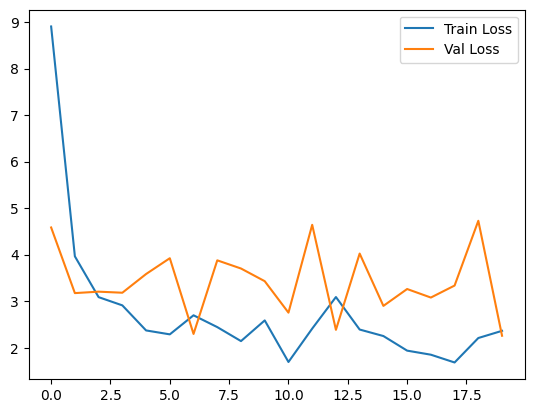

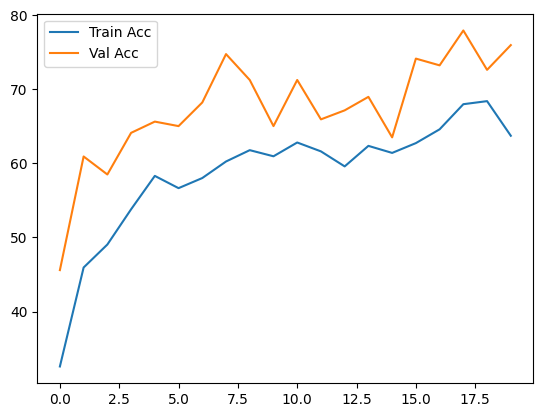

In [24]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [26]:
os.makedirs("saved_models", exist_ok=True)
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_1e-4.pth" )

In [27]:
import pickle
with open("saved_models/ann_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

We can see that its underfitting therefore let's slighltly decrease the lambda. 

This is expected since the model wiht one hidden layer is too simple to detect underlying patterns

In [33]:
lamb = 0.00001

In [34]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.0266 | Val Loss: 3.2201 | Train Acc: 32.9470 | Val Acc: 50.1520
Epoch [2/20] Train Loss: 3.1400 | Val Loss: 2.3765 | Train Acc: 45.5712 | Val Acc: 58.6626
Epoch [3/20] Train Loss: 3.1833 | Val Loss: 2.7000 | Train Acc: 51.5315 | Val Acc: 71.1246
Epoch [4/20] Train Loss: 2.8966 | Val Loss: 3.7543 | Train Acc: 50.6209 | Val Acc: 62.1581
Epoch [5/20] Train Loss: 2.5572 | Val Loss: 2.3727 | Train Acc: 56.4570 | Val Acc: 66.1094
Epoch [6/20] Train Loss: 3.0596 | Val Loss: 3.7519 | Train Acc: 56.6639 | Val Acc: 61.3982
Epoch [7/20] Train Loss: 3.2333 | Val Loss: 3.2044 | Train Acc: 55.1325 | Val Acc: 71.4286
Epoch [8/20] Train Loss: 2.3802 | Val Loss: 3.4478 | Train Acc: 60.8858 | Val Acc: 72.7964
Epoch [9/20] Train Loss: 2.2924 | Val Loss: 3.7180 | Train Acc: 61.7550 | Val Acc: 68.0851
Epoch [10/20] Train Loss: 2.2946 | Val Loss: 4.1560 | Train Acc: 61.7136 | Val Acc: 66.5653
Epoch [11/20] Train Loss: 2.1123 | Val Loss: 4.2183 | Train Acc: 63.57

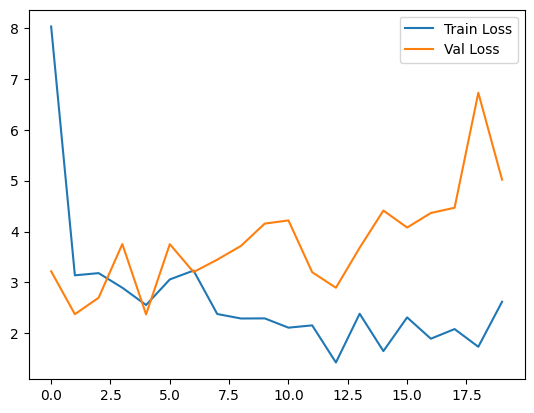

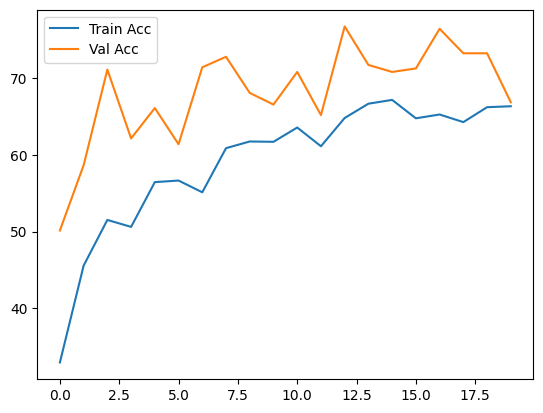

In [38]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [39]:

torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_1e-5.pth" )

In [40]:
with open("saved_models/ann_lambda_1e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

Since the lambda is smaller, volatility increased, we also see a slight increase in accuracy. Let's see what happens when go to a smaller lambda

In [27]:
lamb = 0.000005

In [28]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 7.9561 | Val Loss: 4.7946 | Train Acc: 32.6573 | Val Acc: 51.6717
Epoch [2/20] Train Loss: 4.2591 | Val Loss: 2.4946 | Train Acc: 45.6126 | Val Acc: 59.7264
Epoch [3/20] Train Loss: 2.7096 | Val Loss: 3.2242 | Train Acc: 51.5315 | Val Acc: 67.0213
Epoch [4/20] Train Loss: 2.7248 | Val Loss: 2.4980 | Train Acc: 52.4421 | Val Acc: 60.3343
Epoch [5/20] Train Loss: 2.6443 | Val Loss: 2.9176 | Train Acc: 56.0017 | Val Acc: 63.2219
Epoch [6/20] Train Loss: 2.3066 | Val Loss: 3.9694 | Train Acc: 54.8427 | Val Acc: 63.6778
Epoch [7/20] Train Loss: 3.5896 | Val Loss: 5.0121 | Train Acc: 54.7185 | Val Acc: 56.8389
Epoch [8/20] Train Loss: 2.5956 | Val Loss: 2.9742 | Train Acc: 55.5877 | Val Acc: 65.9574
Epoch [9/20] Train Loss: 2.3231 | Val Loss: 3.1984 | Train Acc: 56.6225 | Val Acc: 63.8298
Epoch [10/20] Train Loss: 2.2911 | Val Loss: 4.2717 | Train Acc: 59.6026 | Val Acc: 72.7964
Epoch [11/20] Train Loss: 1.9011 | Val Loss: 3.8653 | Train Acc: 63.53

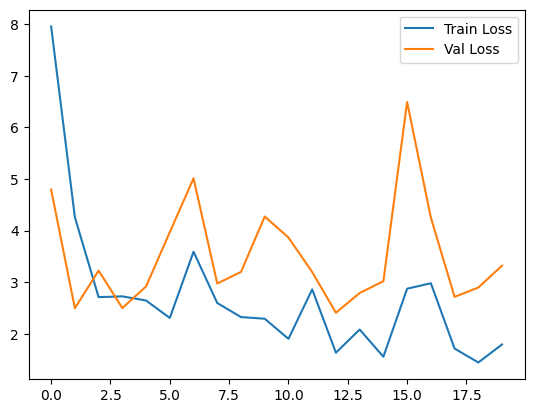

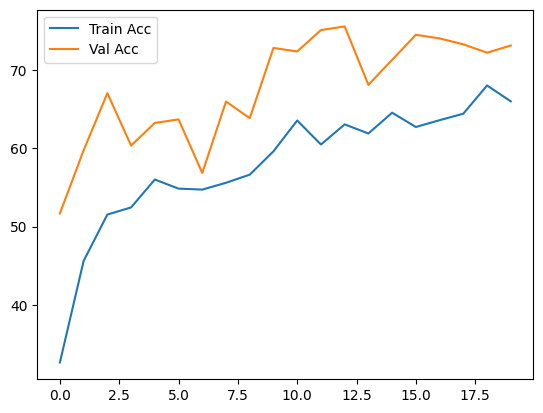

In [29]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [31]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_5e-6.pth" )

In [32]:
with open("saved_models/ann_lambda_5e-6_history.pkl", "wb") as f:
    pickle.dump(history, f)

What happens when we remove regularizations?

In [19]:
lamb = 0

In [20]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.1223 | Val Loss: 2.4513 | Train Acc: 33.5265 | Val Acc: 50.9119
Epoch [2/20] Train Loss: 4.1194 | Val Loss: 3.3940 | Train Acc: 45.8195 | Val Acc: 53.4954
Epoch [3/20] Train Loss: 2.8559 | Val Loss: 3.1562 | Train Acc: 52.7318 | Val Acc: 58.2067
Epoch [4/20] Train Loss: 3.0121 | Val Loss: 3.0723 | Train Acc: 54.2632 | Val Acc: 69.4529
Epoch [5/20] Train Loss: 2.5343 | Val Loss: 3.5671 | Train Acc: 55.7533 | Val Acc: 65.8055
Epoch [6/20] Train Loss: 2.9564 | Val Loss: 2.8228 | Train Acc: 57.5745 | Val Acc: 66.1094
Epoch [7/20] Train Loss: 2.9196 | Val Loss: 4.0068 | Train Acc: 58.1126 | Val Acc: 68.0851
Epoch [8/20] Train Loss: 2.5112 | Val Loss: 3.4167 | Train Acc: 63.6175 | Val Acc: 65.0456
Epoch [9/20] Train Loss: 2.1092 | Val Loss: 2.3281 | Train Acc: 61.1755 | Val Acc: 63.9818
Epoch [10/20] Train Loss: 2.4977 | Val Loss: 2.5018 | Train Acc: 62.2103 | Val Acc: 73.1003
Epoch [11/20] Train Loss: 1.9031 | Val Loss: 3.4799 | Train Acc: 61.96

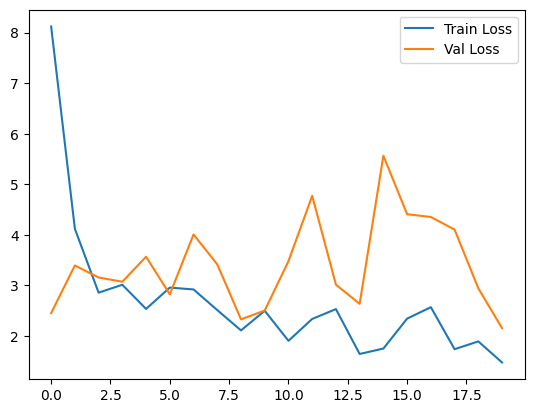

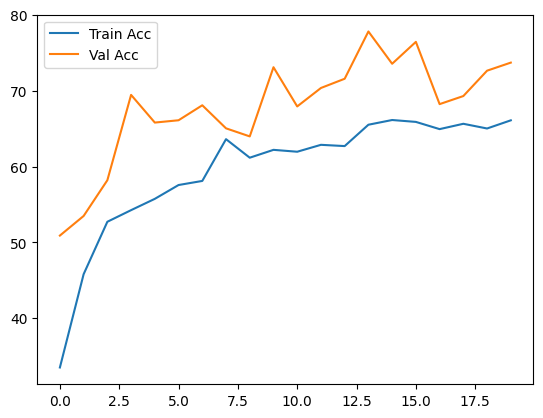

In [21]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [22]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_0.pth")

In [24]:
import pickle
with open("saved_models/ann_lambda_0_history.pkl", "wb") as f:
    pickle.dump(history, f)

On the Contrary let's see what happens when we increase lambda

In [25]:
lamb = 0.0005

In [26]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.6044 | Val Loss: 3.4318 | Train Acc: 31.4983 | Val Acc: 47.8723
Epoch [2/20] Train Loss: 3.7718 | Val Loss: 3.5951 | Train Acc: 43.7914 | Val Acc: 56.6869
Epoch [3/20] Train Loss: 3.4064 | Val Loss: 4.8009 | Train Acc: 50.0828 | Val Acc: 60.3343
Epoch [4/20] Train Loss: 2.9848 | Val Loss: 2.0565 | Train Acc: 55.1325 | Val Acc: 69.6049
Epoch [5/20] Train Loss: 2.6748 | Val Loss: 2.8277 | Train Acc: 57.4089 | Val Acc: 70.3647
Epoch [6/20] Train Loss: 2.0166 | Val Loss: 3.2851 | Train Acc: 61.2169 | Val Acc: 67.9331
Epoch [7/20] Train Loss: 2.4025 | Val Loss: 3.1831 | Train Acc: 58.4437 | Val Acc: 61.8541
Epoch [8/20] Train Loss: 2.4513 | Val Loss: 2.7381 | Train Acc: 60.9272 | Val Acc: 67.0213
Epoch [9/20] Train Loss: 2.0944 | Val Loss: 3.6580 | Train Acc: 62.1689 | Val Acc: 66.2614
Epoch [10/20] Train Loss: 1.9234 | Val Loss: 2.8061 | Train Acc: 62.2103 | Val Acc: 71.5805
Epoch [11/20] Train Loss: 2.2429 | Val Loss: 3.7378 | Train Acc: 62.33

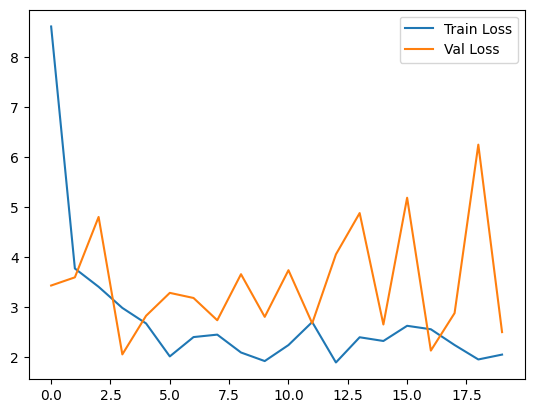

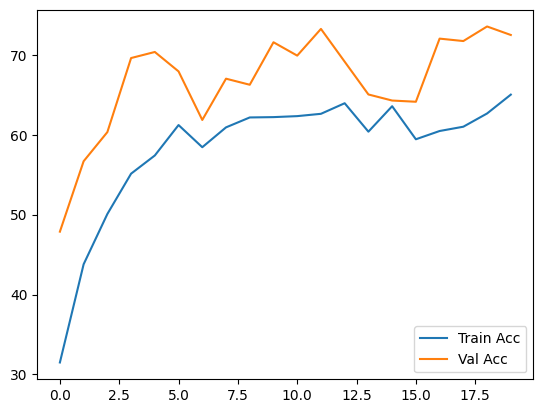

In [27]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [28]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_5e-4.pth")

In [29]:
with open("saved_models/ann_lambda_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

**1 Hidden Layer w/ greyscale**

In [5]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5], std=[0.5])                     
])

In [6]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [7]:
class ANN2(nn.Module):
    def __init__(self, input_size = 128*128, num_classes = 12, dropout = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [8]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [9]:
learning_rate = 0.001
weight_decay = lamb = 0.0001

In [10]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN2().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [66]:
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.1681 | Val Loss: 3.2464 | Train Acc: 25.2070 | Val Acc: 34.1945
Epoch [2/20] Train Loss: 2.7451 | Val Loss: 2.4813 | Train Acc: 35.8444 | Val Acc: 39.5137
Epoch [3/20] Train Loss: 2.3067 | Val Loss: 2.1311 | Train Acc: 39.3626 | Val Acc: 54.2553
Epoch [4/20] Train Loss: 2.3591 | Val Loss: 2.2422 | Train Acc: 44.1225 | Val Acc: 48.1763
Epoch [5/20] Train Loss: 2.0882 | Val Loss: 1.9920 | Train Acc: 44.3709 | Val Acc: 54.4073
Epoch [6/20] Train Loss: 2.0370 | Val Loss: 1.8864 | Train Acc: 45.2401 | Val Acc: 51.5198
Epoch [7/20] Train Loss: 2.1385 | Val Loss: 1.9145 | Train Acc: 47.2268 | Val Acc: 57.5988
Epoch [8/20] Train Loss: 1.9127 | Val Loss: 1.9573 | Train Acc: 51.2003 | Val Acc: 60.9422
Epoch [9/20] Train Loss: 1.7944 | Val Loss: 1.8487 | Train Acc: 52.6904 | Val Acc: 61.5502
Epoch [10/20] Train Loss: 1.8333 | Val Loss: 1.8190 | Train Acc: 53.5182 | Val Acc: 58.8146
Epoch [11/20] Train Loss: 1.7895 | Val Loss: 2.4863 | Train Acc: 53.89

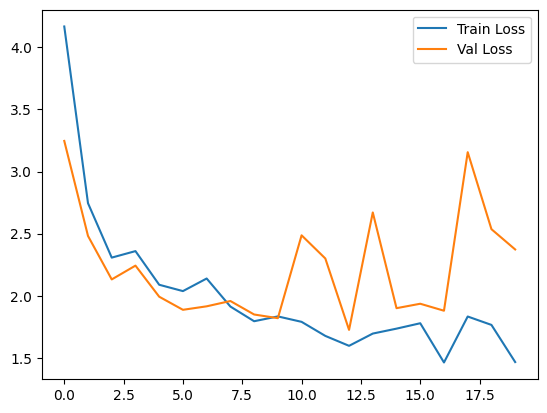

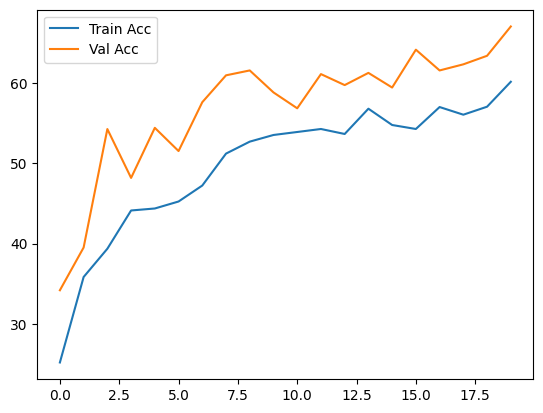

In [67]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [68]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-4.pth")

In [69]:
with open("saved_models/ann-grey_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Underfitting lets try a smaller lambda

In [15]:
lamb = 0.00001
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.4362 | Val Loss: 2.7796 | Train Acc: 25.9520 | Val Acc: 37.8419
Epoch [2/20] Train Loss: 2.7258 | Val Loss: 2.6624 | Train Acc: 36.2997 | Val Acc: 41.9453
Epoch [3/20] Train Loss: 2.2729 | Val Loss: 2.7376 | Train Acc: 42.8808 | Val Acc: 48.9362
Epoch [4/20] Train Loss: 2.2901 | Val Loss: 2.1249 | Train Acc: 43.0464 | Val Acc: 51.3678
Epoch [5/20] Train Loss: 2.0688 | Val Loss: 2.0755 | Train Acc: 47.4752 | Val Acc: 47.5684
Epoch [6/20] Train Loss: 1.9619 | Val Loss: 2.8483 | Train Acc: 45.0745 | Val Acc: 52.8875
Epoch [7/20] Train Loss: 1.9277 | Val Loss: 2.4682 | Train Acc: 47.5579 | Val Acc: 53.6474
Epoch [8/20] Train Loss: 1.7690 | Val Loss: 1.8969 | Train Acc: 49.3377 | Val Acc: 58.0547
Epoch [9/20] Train Loss: 1.8305 | Val Loss: 2.3663 | Train Acc: 51.3245 | Val Acc: 58.8146
Epoch [10/20] Train Loss: 1.7551 | Val Loss: 1.9926 | Train Acc: 54.2632 | Val Acc: 62.4620
Epoch [11/20] Train Loss: 1.7376 | Val Loss: 1.9759 | Train Acc: 53.47

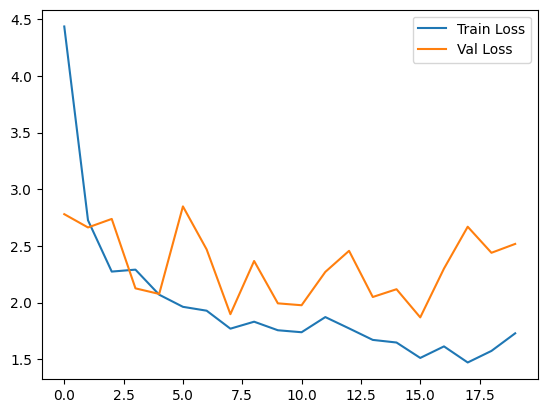

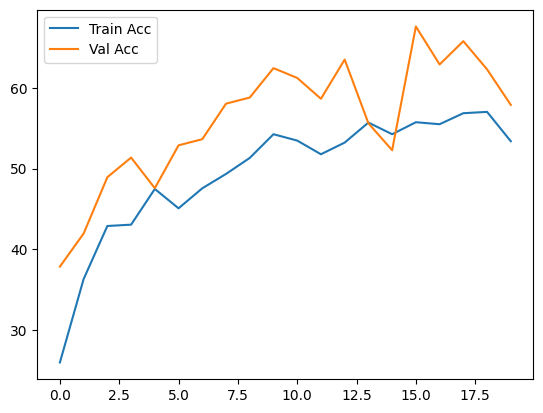

In [16]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [17]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-5.pth")

In [18]:
with open("saved_models/ann-grey_lambda_1e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

it seems like lowering the lambda reduced accurracy. lets try something in between

In [19]:
lamb = 0.00005
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.5884 | Val Loss: 2.1372 | Train Acc: 27.8146 | Val Acc: 38.6018
Epoch [2/20] Train Loss: 2.5559 | Val Loss: 2.3782 | Train Acc: 37.4586 | Val Acc: 48.3283
Epoch [3/20] Train Loss: 2.3887 | Val Loss: 2.1874 | Train Acc: 40.8940 | Val Acc: 44.5289
Epoch [4/20] Train Loss: 2.2745 | Val Loss: 2.3365 | Train Acc: 42.4255 | Val Acc: 48.1763
Epoch [5/20] Train Loss: 2.1915 | Val Loss: 1.9717 | Train Acc: 44.2467 | Val Acc: 56.3830
Epoch [6/20] Train Loss: 2.0945 | Val Loss: 2.2532 | Train Acc: 47.3096 | Val Acc: 49.8480
Epoch [7/20] Train Loss: 1.7953 | Val Loss: 2.0843 | Train Acc: 47.9719 | Val Acc: 59.1185
Epoch [8/20] Train Loss: 1.8538 | Val Loss: 2.1142 | Train Acc: 49.9586 | Val Acc: 55.0152
Epoch [9/20] Train Loss: 1.8725 | Val Loss: 2.2516 | Train Acc: 48.8825 | Val Acc: 53.9514
Epoch [10/20] Train Loss: 1.8396 | Val Loss: 2.2717 | Train Acc: 51.6970 | Val Acc: 62.7660
Epoch [11/20] Train Loss: 1.8356 | Val Loss: 2.3224 | Train Acc: 51.49

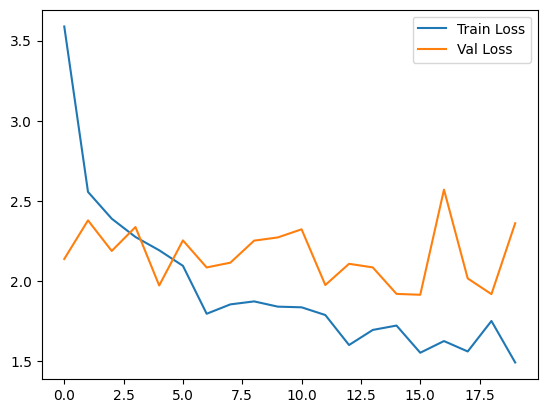

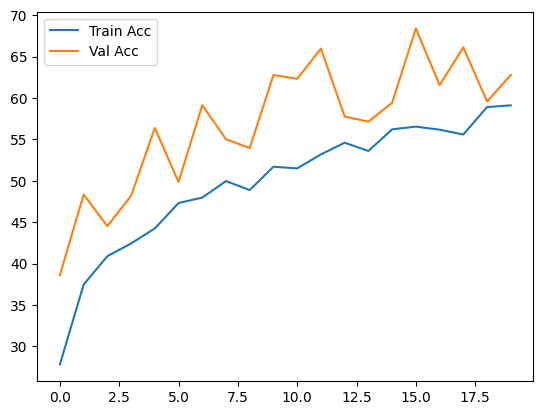

In [20]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [ ]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_5e-5.pth")

In [ ]:
with open("saved_models/ann-grey_lambda_5e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

Seems like the accuracy improved. Let's try something betweeen both


In [23]:
lamb = 0.000075
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.7607 | Val Loss: 3.0876 | Train Acc: 27.4421 | Val Acc: 31.4590
Epoch [2/20] Train Loss: 2.7228 | Val Loss: 2.8242 | Train Acc: 37.6242 | Val Acc: 45.2888
Epoch [3/20] Train Loss: 2.5981 | Val Loss: 2.1796 | Train Acc: 41.2666 | Val Acc: 45.5927
Epoch [4/20] Train Loss: 2.4388 | Val Loss: 2.1817 | Train Acc: 43.0050 | Val Acc: 48.7842
Epoch [5/20] Train Loss: 2.2581 | Val Loss: 2.1007 | Train Acc: 45.7781 | Val Acc: 51.2158
Epoch [6/20] Train Loss: 2.5439 | Val Loss: 2.0594 | Train Acc: 45.9851 | Val Acc: 49.0881
Epoch [7/20] Train Loss: 1.8445 | Val Loss: 2.1210 | Train Acc: 47.6821 | Val Acc: 53.1915
Epoch [8/20] Train Loss: 1.7950 | Val Loss: 1.9254 | Train Acc: 49.4619 | Val Acc: 49.5441
Epoch [9/20] Train Loss: 1.9774 | Val Loss: 2.2699 | Train Acc: 46.0679 | Val Acc: 48.1763
Epoch [10/20] Train Loss: 1.8341 | Val Loss: 2.6981 | Train Acc: 49.3377 | Val Acc: 57.9027
Epoch [11/20] Train Loss: 1.8281 | Val Loss: 2.3483 | Train Acc: 51.94

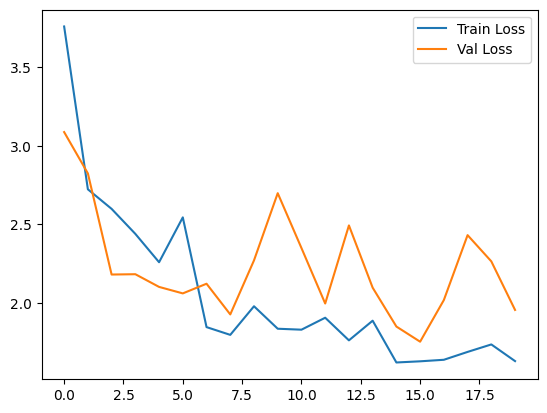

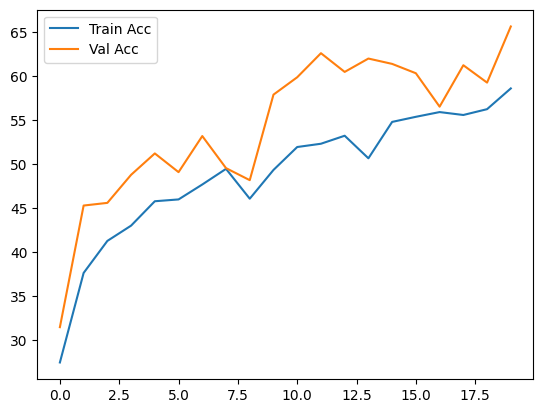

In [24]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [25]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_7_5e-5.pth")

In [26]:
with open("saved_models/ann-grey_lambda_7_5e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

It doesn't seem like we are better 1e-4's accuracy. Let's try something larger

In [27]:
lamb = 0.001
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.1809 | Val Loss: 2.8122 | Train Acc: 25.7864 | Val Acc: 35.7143
Epoch [2/20] Train Loss: 2.7572 | Val Loss: 2.6344 | Train Acc: 35.2235 | Val Acc: 40.1216
Epoch [3/20] Train Loss: 2.4092 | Val Loss: 2.0249 | Train Acc: 38.4106 | Val Acc: 39.0578
Epoch [4/20] Train Loss: 2.1840 | Val Loss: 2.6466 | Train Acc: 42.7152 | Val Acc: 48.9362
Epoch [5/20] Train Loss: 2.2359 | Val Loss: 1.7429 | Train Acc: 42.8808 | Val Acc: 55.9271
Epoch [6/20] Train Loss: 2.1002 | Val Loss: 2.2870 | Train Acc: 47.2268 | Val Acc: 50.4559
Epoch [7/20] Train Loss: 2.0477 | Val Loss: 2.4128 | Train Acc: 45.8195 | Val Acc: 54.5593
Epoch [8/20] Train Loss: 1.9136 | Val Loss: 2.3301 | Train Acc: 48.3444 | Val Acc: 56.2310
Epoch [9/20] Train Loss: 1.9842 | Val Loss: 2.1632 | Train Acc: 49.5447 | Val Acc: 62.0061
Epoch [10/20] Train Loss: 1.9267 | Val Loss: 1.9556 | Train Acc: 49.1722 | Val Acc: 60.0304
Epoch [11/20] Train Loss: 1.9593 | Val Loss: 2.0422 | Train Acc: 50.24

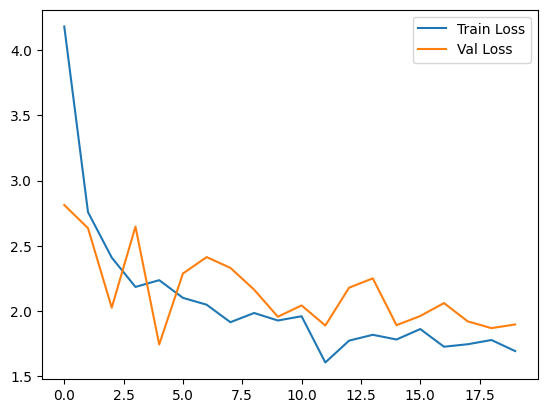

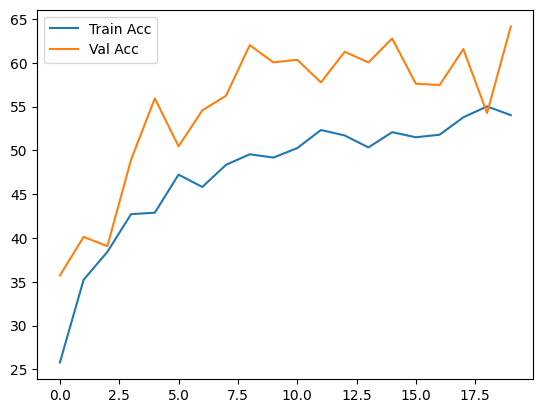

In [28]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [29]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-3.pth")

In [30]:
with open("saved_models/ann-grey_lambda_1e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

Ok let's try a number between 1e-4 and 1e-3

In [31]:
lamb = 0.0005
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.6964 | Val Loss: 3.0852 | Train Acc: 27.1523 | Val Acc: 35.7143
Epoch [2/20] Train Loss: 2.7263 | Val Loss: 2.5192 | Train Acc: 36.7964 | Val Acc: 39.3617
Epoch [3/20] Train Loss: 2.4339 | Val Loss: 2.2324 | Train Acc: 39.8179 | Val Acc: 47.1125
Epoch [4/20] Train Loss: 2.4900 | Val Loss: 3.2476 | Train Acc: 42.7566 | Val Acc: 50.6079
Epoch [5/20] Train Loss: 2.1659 | Val Loss: 2.5502 | Train Acc: 45.3228 | Val Acc: 57.1429
Epoch [6/20] Train Loss: 1.9470 | Val Loss: 1.9832 | Train Acc: 47.7235 | Val Acc: 58.5106
Epoch [7/20] Train Loss: 1.8660 | Val Loss: 2.0551 | Train Acc: 47.8477 | Val Acc: 59.1185
Epoch [8/20] Train Loss: 1.8702 | Val Loss: 2.1525 | Train Acc: 50.9934 | Val Acc: 52.1277
Epoch [9/20] Train Loss: 1.9099 | Val Loss: 1.9691 | Train Acc: 51.2417 | Val Acc: 60.0304
Epoch [10/20] Train Loss: 1.9101 | Val Loss: 2.2164 | Train Acc: 51.5315 | Val Acc: 60.1824
Epoch [11/20] Train Loss: 1.7415 | Val Loss: 2.1998 | Train Acc: 51.15

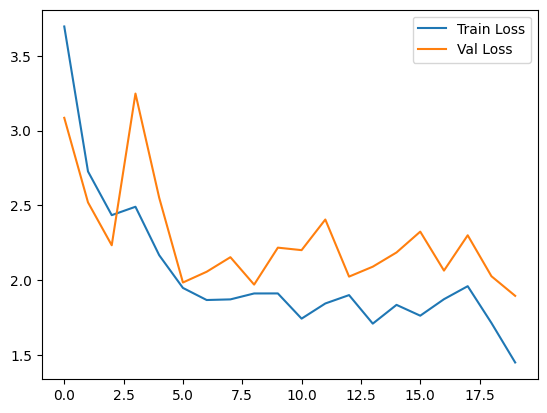

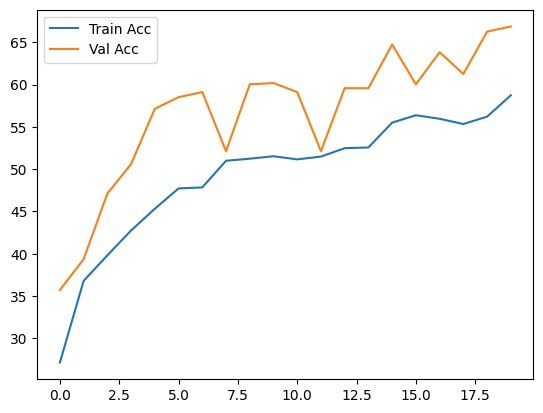

In [32]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [33]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_5e-4.pth")

In [34]:
with open("saved_models/ann-grey_lambda_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Seems like 5e-4 to 1e-4 is the right lambda

**2 Hidden Layers**